# 오디오 처리(Audio Processing)

- 일상생활에서 소리는 진동으로 인한 공기의 압축으로 생성 (공기의 진동)
- 압축이 얼마나 됐냐에 따라 진동하며, 공간이나 매질을 전파해 나가는 현상은 Wave(파동)으로 표현
- Information of Sound's Wave
    - 위상(Phase; Degress of displacement)
    - 진폭(Amplitude; Intensity)
    - 주파수(Frequency)

# 오디오 라이브러리
- Python에서 사용 가능한 librosa : 음성 처리에 유용한 라이브러리
- colab 환경에서는 torchaudio 사용 가능

# 라이브러리

In [ ]:
!pip install librosa

In [ ]:
!pip install torchaudio

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import librosa
import librosa.display
import torch
import torchaudio
import IPython.display as ipd

# 데이터셋 구축
- torchaudio 에서 제공해주는 내장 데이터셋 사용


In [4]:
train_dataset = torchaudio.datasets.LIBRISPEECH('./', url = 'train-clean-100', download=False)
test_dataset = torchaudio.datasets.LIBRISPEECH('./', url = 'test-clean', download=False)

  0%|          | 0.00/5.95G [00:00<?, ?B/s]

  0%|          | 0.00/331M [00:00<?, ?B/s]

## 데이터 확인
- 첫번째 줄에서는 소리 데이터 확인
- 두번째 줄에서는 해당 데이터의 sampling rate 확인

In [ ]:
# 전체 데이터 개수 확인
print(len(train_dataset))

# 첫번째 소리 데이터 확인
print(train_dataset[0][0])

# 첫번째 소리 데이터 sampling rate 확인
print(train_dataset[0][1])

1545
tensor([[ 1.3123e-03,  2.5635e-03,  1.5259e-03,  ..., -3.9062e-03,
         -3.0518e-05, -1.9531e-03]])
16000


# 샘플링(Sampling)

## Sampling

- 음성을 처리하기 위해 소리라는 아날로그 정보를 디지털 정보로 표현하기 위해 잘게 쪼개 이산적인 데이터로!
- 이 때, 무한히 쪼개서 저장할 수 없으므로, 기준을 세워 아날로그 정보를 쪼개 대표값 사용 == 샘플링(Sampling)
- 주로 사용할 때, 연속적인 데이터 형태를 시간을 기준으로 아날로그 정보를 쪼개는 `Time Domain` 방식 사용

### Sampling Rate

- sampling rate는 아날로그 정보를 얼마나 잘게 쪼갤지 결정
- 잘게 쪼갤수록 정보 손실이 줄어들지만, 데이터의 크기가 늘어남

### Sampling theorem

- sampling rate가 최대 frequency보다 2배 커져야 한다!
- 일반적으로 sampling은 인간의 청각 영역에 맞게 형성 돼야 한다.
    - Audio CD : 44.1kHz(44100 sample/second)
    - Speech communication : 8kHz(8000 sample/second) (ex. 전화 통화 품질이라고 보면 됨!)

### 음성의 duration은 데이터의 길이와 sampling rate를 나누어서 확인 가능하다

In [5]:
audio_data  = test_dataset[1][0][0]
sampling_rate = test_dataset[1][1]

print(audio_data, sampling_rate)
print('length:', len(audio_data))
print('duration:', len(audio_data)/sampling_rate)

ipd.Audio(audio_data, rate=sampling_rate)

tensor([ 0.0010,  0.0011,  0.0009,  ..., -0.0007, -0.0010, -0.0011]) 16000
length: 52400
duration: 3.275


## resampling

- resampling은 sampling data의 sampling rate를 조정해서 다시 sampling 하는 작업
- 주로 low-pass filter을 사용해서 보간(interpolation)을 한다
- `librosam.resample` 라이브러리를 사용해서 편하게 resampling 가능!
- 현재 우리가 사용하는 데이터는 `torch tensor` 형식이고, librosa는 `numpy`배열을 취급하기 때문에 변환해야 한다.
- sampling rate를 절반으로 줄리면, 길이도 절반으로 준 것을 확인할 수 있다.

In [ ]:
# torch tensor로 이뤄져 있는 data를 numpy로 변환
audio_numpy = audio_data.numpy()

# 8k 로 resampling 시도
y_8k = librosa.resample(audio_numpy, sampling_rate, 8000)

# 8k로 resample 한 데이터의 length와 duration 확인
print('8k length :', len(y_8k))
print('8k duration :', len(y_8k) / 8000)

# sampling rate가 8000인 sound
ipd.Audio(y_8k, rate=8000)

8k length : 26200
8k duration : 3.275


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 4000으로 resampling
# sampling의 의미 : 초당 4000개의 sample로 sound data 구성
# 8000개나 16000개 보다 적어서 소리가 뭉개진다.

# Normalization

> - 데이터 내에서 음량이 제각각인 경우가 많은데, 이럴 때 정규화 작업으로 amplitude를 [-1,1] 범위로 조정한다.
> - 간단한 방법으로 데이터의 최대값을 나눠 정규화 하는 방법이 있다.

In [16]:
# 오디오 데이터를 numpy 배열로 바꾸기
audio_np = audio_data.numpy()

# 절대값의 최대값으로 나눠주기
normed_wav = audio_np / max(np.abs(audio_np))

# 음원 출력
ipd.Audio(normed_wav, rate=sampling_rate)

# Quanization
> - 음질은 떨어지고, 노이즈가 발생하는 대신에 용량이 줄어든다.

In [ ]:
bit = 8
max_value = 2 ** (bit-1)

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav).astype(int)
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value-1)

ipd.Audio(quantized_8_wav, rate=sampling_rate)


# Mu-Law Encoding

> - 사람은 작은 소리에는 예민하게 반응하지만 소리가 커질수록 차이를 잘 느끼지 못하는 청각능력을 보유하고 있다.
> - 이 개념을 응용하여 소리 파동인 wave값을 표현할 때, 작은 값에는 높은 분별력을 부여하고, 큰 값에는 낮은 분별력을 갖도록 할 수 있다.

In [13]:
def mu_law(x, mu=255):
    # np.sign ==> 0보다 작으면 -1, 0이면 0, 0보다 크면 1을 출력해준다.
    # Mu Law를 실현하는 공식같음
    return np.sign(x) * np.log(1 + mu*np.abs(x)) / np.log(1 + mu)

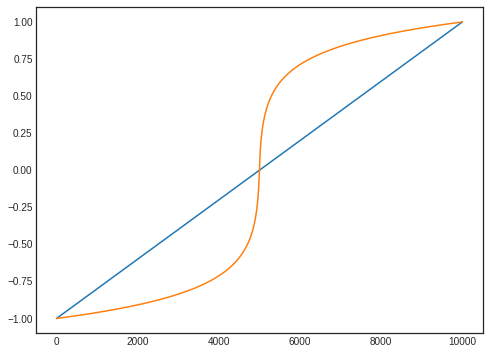

In [15]:
# 이해를 돕기 위해 예시로 임의의 데이터로 확인
x= np.linspace(-1,1,10000)
x_mu = mu_law(x)

plt.figure(figsize=(8,6))
plt.plot(x)
plt.plot(x_mu)
plt.show()

In [19]:
mu_audio = mu_law(normed_wav)
ipd.Audio(mu_audio, rate=sampling_rate)